# Image Processing and Classification with VGG16

## What is VGG16

Quoted from [Geeks For Geeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/) -- The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers, including 13 convolutional layers and 3 fully connected layers. VGG-16 is renowned for its simplicity and effectiveness, as well as its ability to achieve strong performance on various computer vision tasks, including image classification and object recognition. The model’s architecture features a stack of convolutional layers followed by max-pooling layers, with progressively increasing depth. This design enables the model to learn intricate hierarchical representations of visual features, leading to robust and accurate predictions. Despite its simplicity compared to more recent architectures, VGG-16 remains a popular choice for many deep learning applications due to its versatility and excellent performance.

## Goal
Using 100 images acquired from the Ravelry API, create a model that can predict what kind of garment is in the image - hat, pullover, or socks.  VGG16 will be used as it is a simple CNN, but effective with image classification.

Images were split into 70/30 testing/training sets. Referenced Shriram Vasudevan's [YouTube](https://www.youtube.com/watch?v=bEsRLXY7GCo&t=18s) and code for structure of model.  Also referenced [Keras](https://keras.io/api/applications/vgg/) for argument clarifications.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import keras, os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import seaborn as sns
sns.set(style = 'whitegrid')

from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
train_images = '/content/drive/My Drive/ravelry_project/train'
test_images = '/content/drive/My Drive/ravelry_project/test'
unseen_socks = '/content/drive/My Drive/ravelry_project/images/my_socks.jpg'
unseen_pullover = '/content/drive/My Drive/ravelry_project/images/my_pullover.jpg'
unseen_hat = '/content/drive/My Drive/ravelry_project/images/my_hat.jpg'

DO NOT USE IMAGE AS A VARIABLE.  Learned this the hard way.  Referenced this from Shriram Vasudeval's video titled [VGG16 Architecture and Implementation](https://www.youtube.com/watch?v=bEsRLXY7GCo&t=18s)

In [37]:
# Process an unseen image for testing
def prep_unseen_image(unseen_image):
  img = image.load_img(unseen_image, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array = img_array / 255.
  img_array = preprocess_input(img_array)
  return img_array




In [55]:
def predict_garment(model, unseen_image):
  img_array = prep_unseen_image(unseen_image)
  prediction = model.predict(img_array)
  pred_class = np.argmax(prediction,axis=1)[0]
  class_labels = ['Hat', 'Pullover', 'Socks']
  pred_label =  class_labels[pred_class]

  img = image.load_img(unseen_image)
  plt.imshow(img)
  plt.title(f'Predicted: {pred_label}')
  plt.axis('off')
  plt.show()


In [18]:
def display_image(img, predicted_label, true_label, status):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}, True: {true_label}, Status: {status}')
    plt.show()

ImageDataGenerator takes images and randomly transforms them for the purpose of making the training dataset larger.  Referenced [Image Data Augmentation using Keras ImageDataGenerator](https://medium.com/featurepreneur/image-data-augmentation-using-keras-imagedatagenerator-1cee60255ea8) for information and settings.

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1./255, #Normalize the pixels so it's easier to parse
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Batch size at 5 was 81%.  Lowered to 3 and accuracy increased to 84%.  Batch size of two lowered accuracy to 78%, so kept at 3.

Best interation was training batch size at 7 and test batch size at 3 with 5 epochs.

In [20]:
train_gen = train_datagen.flow_from_directory(
    train_images,
    target_size=(224,224),
    batch_size=7,
    class_mode='categorical' # this is set to categorical because I'm dealing with more than two categories
)

test_gen = test_datagen.flow_from_directory(
    test_images,
    target_size=(224,224),
    batch_size=3,
    class_mode = 'categorical'

)

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


The default VGG16 model.  I don't want to train it.

In [21]:
vgg_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
vgg_model.trainable = False

In [22]:
# Add in extra layers at the end.  The last layers gets 3 units for three categories
model = keras.Sequential([
    vgg_model,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation = 'relu'),
    keras.layers.Dense(units=256, activation = 'relu'),
    keras.layers.Dense(units=3, activation = 'softmax')
])

In [23]:
# Compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)


In [25]:
# Fit model - Floor division may not be necessary because my batch sizes can divide evenly with training and test image count.
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.samples // test_gen.batch_size,
    epochs=5
)

Epoch 1/5
30/30 [==============================] - 182s 6s/step - loss: 2.2251 - acc: 0.4095 - val_loss: 0.8777 - val_acc: 0.6333
Epoch 2/5
30/30 [==============================] - 204s 7s/step - loss: 0.9101 - acc: 0.6714 - val_loss: 0.5751 - val_acc: 0.7889
Epoch 3/5
30/30 [==============================] - 168s 6s/step - loss: 0.6261 - acc: 0.7714 - val_loss: 1.1120 - val_acc: 0.6000
Epoch 4/5
30/30 [==============================] - 178s 6s/step - loss: 0.4471 - acc: 0.8524 - val_loss: 0.5471 - val_acc: 0.8222
Epoch 5/5
30/30 [==============================] - 172s 6s/step - loss: 0.5712 - acc: 0.7524 - val_loss: 0.6852 - val_acc: 0.7000


In [26]:
# Save the model
model.save('ravimg.keras')

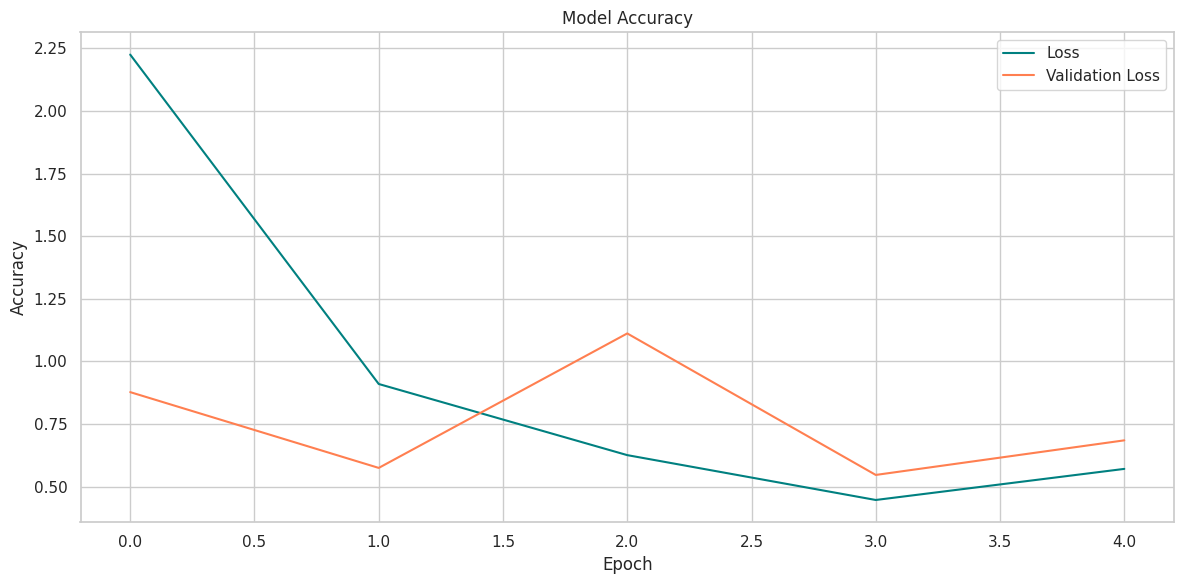

In [27]:
# Plot size
plt.figure(figsize = (12,6))

plt.plot(history.history['loss'], c = 'teal')
plt.plot(history.history['val_loss'], c = 'coral')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss','Validation Loss'])

plt.tight_layout()

plt.savefig('/content/drive/My Drive/ravelry_project/plots/vgg16_loss', dpi = 192);

In [28]:
# Model Accuracy?
model.evaluate(test_gen)

30/30 [==============================] - 49s 2s/step - loss: 0.6852 - acc: 0.7000


[0.6851502060890198, 0.699999988079071]

In [29]:
y_pred = np.argmax(model.predict(test_gen), axis = 1)


30/30 [==============================] - 49s 2s/step


## Hank - Help

I am trying to make something akin to your code where you had the number images listed along with text described the actual and predicted classes for a number misclassified photos. I can't figure it out.  I can get a list of images with text, but the information doesn't match up.  Sometimes it's obviously a hat, but the actual class is 'pullover'.  I feel that it might have to do with the fact that test batches are three photos at a time, so the array is more complex.  Guess it's not necessary for the model, but it's nice to see how it's not working.

In [62]:
test_gen.classes, y_`pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2], dtype=int32),
 array([0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1,
        1, 0, 2, 1, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 1, 2, 0, 1, 1,
        1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1,
        1, 2]))

In [64]:
class_names = {v: k for k, v in test_gen.class_indices.items()}
class_names

{0: 'hat', 1: 'pullover', 2: 'socks'}

In [32]:
wrong_garment_indices = np.where(y_pred != test_gen.classes)[0]

# Iterate through misclassified images and display them
for i in wrong_garment_indices[:10]:
    plt.clf()  # Clears plot - will overwrite otherwise
    try:
        # Retrieve the corresponding batch index and image index within the batch
        batch_index = i // test_gen.batch_size
        image_index = i % test_gen.batch_size

        # Retrieve the corresponding batch from the generator
        test_images, true_labels = test_gen[batch_index]

        # Get the predicted label
        pred = y_pred[i]
        predicted_label = class_names[pred]

        # Get the true label name
        true_label_index = np.argmax(true_labels[image_index])
        true_label_name = class_names[true_label_index]

        # Determine if the prediction is correct
        prediction_status = 'Correct' if pred == true_label_index else 'Incorrect'

        # Display the image
        display_image(test_images[image_index], predicted_label, true_label_name, prediction_status)

        print(f'We thought = {predicted_label}, but really {true_label_name}, Status: {prediction_status}')
    except Exception as e:
        print(f"Error occurred: {e}")

Output hidden; open in https://colab.research.google.com to view.

## Hank - Help

Is this actually working? I think it is, but I would feel better if someone with more experience told me if I'm on the right track or not.

1/1 [==============================] - 1s 601ms/step


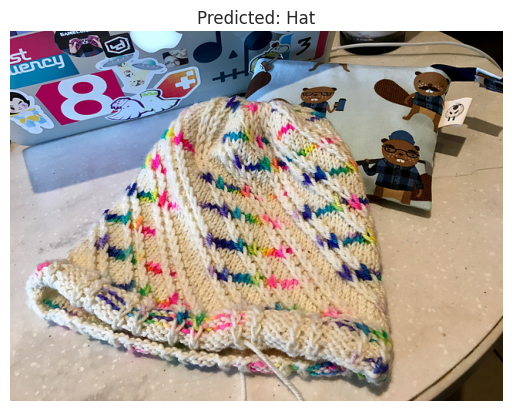

In [56]:
predict_garment(model, unseen_hat)